In [ ]:
# 라이브러리 불러오기
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# MNIST dataset 불러오기
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 0~255의 픽셀값을 0~1 사이 실수로 정규화
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape the input data for CNN
x_train = x_train.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1))

# MNIST 손글씨 숫자를 분류하는 CNN 모델 만들기
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu'),    # 5x5 convolution layer with 32 channels
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), activation='relu'),    # 5x5 convolution layers with 64 channels
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),            # a fully connected layer with 512 units and ReLu activation
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')           # a final softmax output layer
])

# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Partitioning
num_clients = 100
B = 10
partition_type = "Non-IID"  # "IID" 또는 "Non-IID" 선택

if partition_type == "IID":
    indices = np.arange(len(x_train))                                                     # 데이터셋의 인덱스 생성
    np.random.shuffle(indices)                                                            # 인덱스 배열을 무작위로 섞는다
    client_indices_list = [indices[i * 600 : (i + 1) * 600] for i in range(num_clients)]  # client에게 인덱스 분배

# 코드 수정
elif partition_type == "Non-IID":
    num_labels = 10
    shards = 200
    shard_size = 300
    shards_per_client = 2

    client_indices_list = []

    # 데이터를 레이블 별로 정렬
    sorted_indices = np.argsort(y_train)
    x_train_sorted = x_train[sorted_indices]
    y_train_sorted = y_train[sorted_indices]

    for i in range(num_clients):
        selected_shards = np.random.choice(shards, shards_per_client, replace=False)
        client_indices = []

        for shard in selected_shards:
            shard_start = shard * shard_size
            shard_end = (shard + 1) * shard_size
            shard_indices = np.arange(shard_start, shard_end)
            shard_labels = y_train_sorted[shard_indices]
            unique_labels, label_counts = np.unique(shard_labels, return_counts=True)

            # 각 클라이언트에게 최대 2개의 레이블만 할당
            selected_labels = unique_labels[:2]
            selected_label_indices = [shard_indices[shard_labels == label] for label in selected_labels]
            selected_samples = []

            # 샘플 크기를 레이블당 최대 shard_size // 2로 제한
            max_samples_per_label = shard_size // 2

            for label_indices in selected_label_indices:
                if len(label_indices) > max_samples_per_label:
                    selected_samples.extend(np.random.choice(label_indices, max_samples_per_label, replace=False))
                else:
                    selected_samples.extend(label_indices)

            client_indices.extend(selected_samples)

        client_indices_list.append(client_indices)

    # Shuffle the client indices for randomness
    for indices in client_indices_list:
        np.random.shuffle(indices)

# 클라이언트마다 할당된 레이블 확인
for client_idx, indices in enumerate(client_indices_list):
    client_labels = y_train[indices]
    unique_labels, label_counts = np.unique(client_labels, return_counts=True)

    label_counts_str = ', '.join([f"{label}:{count}" for label, count in zip(unique_labels, label_counts)])
    print(f"Client {client_idx + 1}의 레이블과 개수: {label_counts_str}")


# Define client update function using model.fit
def client_update(client_x, client_y, B, E):
    # EarlyStopping 콜백 정의
    early_stopping = EarlyStopping(monitor='accuracy', patience=3, mode='max', verbose=1)

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # EarlyStopping 콜백을 적용하여 모델 훈련
    history = model.fit(client_x, client_y, batch_size=B, epochs=E, callbacks=[early_stopping], verbose=1)

    return history.history['accuracy'][-1]  # Return the accuracy after the last epoch

Client 1의 레이블과 개수: 0:36, 1:33, 2:24, 3:36, 4:27, 5:28, 6:36, 7:30, 8:28, 9:22
Client 2의 레이블과 개수: 0:38, 1:42, 2:41, 3:45, 4:34, 5:37, 6:44, 7:34, 8:24, 9:38
Client 3의 레이블과 개수: 0:36, 1:40, 2:36, 3:45, 4:32, 5:33, 6:45, 7:38, 8:29, 9:43
Client 4의 레이블과 개수: 0:32, 1:29, 2:31, 3:35, 4:26, 5:28, 6:28, 7:34, 8:33, 9:24
Client 5의 레이블과 개수: 0:29, 1:37, 2:23, 3:30, 4:22, 5:29, 6:34, 7:27, 8:33, 9:36
Client 6의 레이블과 개수: 0:34, 1:38, 2:33, 3:27, 4:25, 5:27, 6:29, 7:32, 8:31, 9:24
Client 7의 레이블과 개수: 0:28, 1:29, 2:34, 3:29, 4:25, 5:37, 6:25, 7:28, 8:32, 9:33
Client 8의 레이블과 개수: 0:36, 1:41, 2:25, 3:39, 4:28, 5:20, 6:27, 7:28, 8:26, 9:30
Client 9의 레이블과 개수: 0:33, 1:33, 2:25, 3:33, 4:33, 5:19, 6:29, 7:36, 8:35, 9:24
Client 10의 레이블과 개수: 0:27, 1:34, 2:24, 3:41, 4:26, 5:23, 6:30, 7:34, 8:30, 9:31
Client 11의 레이블과 개수: 0:22, 1:39, 2:43, 3:24, 4:28, 5:28, 6:31, 7:32, 8:31, 9:22
Client 12의 레이블과 개수: 0:26, 1:34, 2:29, 3:25, 4:26, 5:25, 6:38, 7:28, 8:32, 9:37
Client 13의 레이블과 개수: 0:26, 1:32, 2:24, 3:33, 4:28, 5:30, 6:26,

Epoch 1/20
60/60 [==============================] - 3s 22ms/step - loss: 0.2339 - accuracy: 0.9050
Epoch 2/20
60/60 [==============================] - 1s 22ms/step - loss: 0.0202 - accuracy: 0.9917
Epoch 3/20
60/60 [==============================] - 1s 20ms/step - loss: 0.0064 - accuracy: 0.9983
Epoch 4/20
60/60 [==============================] - 2s 27ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 5/20
60/60 [==============================] - 2s 35ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 6/20
60/60 [==============================] - 2s 29ms/step - loss: 4.1321e-04 - accuracy: 1.0000
Epoch 7/20
60/60 [==============================] - 1s 20ms/step - loss: 1.7090e-04 - accuracy: 1.0000
Epoch 7: early stopping
Client 38 - Accuracy after 20 epochs: 1.0000
Epoch 1/20
60/60 [==============================] - 2s 19ms/step - loss: 1.4240 - accuracy: 0.8000
Epoch 2/20
60/60 [==============================] - 1s 20ms/step - loss: 0.0237 - accuracy: 0.9933
Epoch 3/20
60/60 [==============

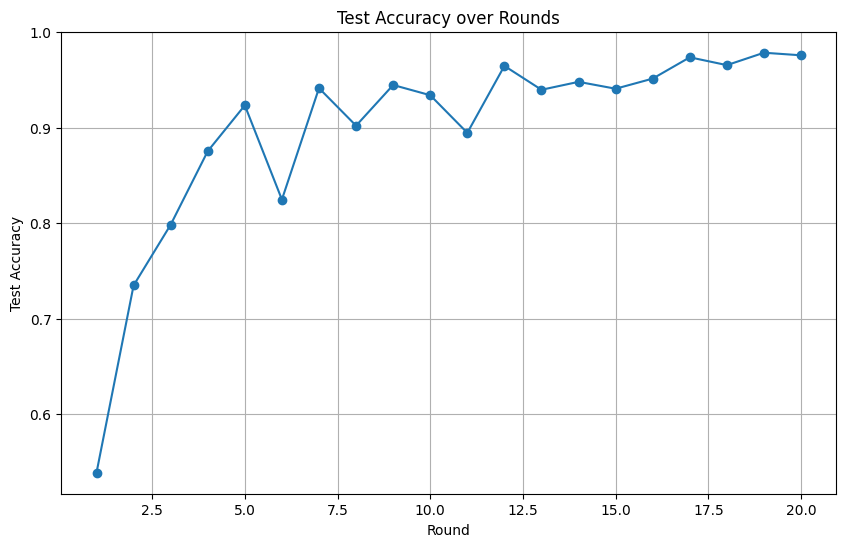

In [ ]:
# Training loop

# 상수
num_rounds = 20
E = 20
learning_rate = 0.1
C = 0.1

# 초기값 설정
w = model.get_weights()

# 라운드 번호와 해당 라운드의 테스트 정확도 저장할 리스트
rounds_list = []
test_acc_list = []

# Federated averaging training loop
for t in range(num_rounds):
    m = max(int(C * num_clients), 1)
    selected_clients = np.random.choice(num_clients, m, replace=False)

    client_updates = []
    for client_idx in selected_clients:
        client_x = x_train[client_indices_list[client_idx]]
        client_y = y_train[client_indices_list[client_idx]]

        with tf.device('GPU'):
            client_acc = client_update(client_x, client_y, B, E)
            print(f"Client {client_idx + 1} - Accuracy after {E} epochs: {client_acc:.4f}")

        client_updates.append(model.get_weights())  # client마다 업데이트한 가중치를 client_updates에 저장

    averaged_weights = [np.mean([client_weights[i] for client_weights in client_updates], axis=0) for i in range(len(w))]   # w의 가중평균 계산
    model.set_weights(averaged_weights)  # 모델 가중치 업데이트

    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

    # Store results
    rounds_list.append(t + 1)
    test_acc_list.append(test_acc)

    print(f"Round {t + 1} - Test accuracy: {test_acc:.4f}")

# Plot the test accuracy over rounds
plt.figure(figsize=(10, 6))
plt.plot(rounds_list, test_acc_list, marker='o')
plt.title("Test Accuracy over Rounds")
plt.xlabel("Round")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.show()